# Implementation of FIR Filter in the FPGA

In [3]:
import numpy as np
from numpy import savetxt, loadtxt
import matplotlib.pyplot as plt

In [27]:
# Let us generate a wave function with two main frequencies, an high one and a low one:

data_size = 250
noise = 1 # the higher the noisier
file = open("../signal.txt", "w")


input_sig = []

for i in range(data_size):
    sig = 53*(2+np.sin(i/(11*np.pi))+ noise)
    noise = -noise
    input_sig.append(sig.astype(int)) # we write it as an int
    file.write(str(sig.astype(int)))
    file.write('\n')

file.close()

In [28]:
print(min(input_sig),max(input_sig))

0 211


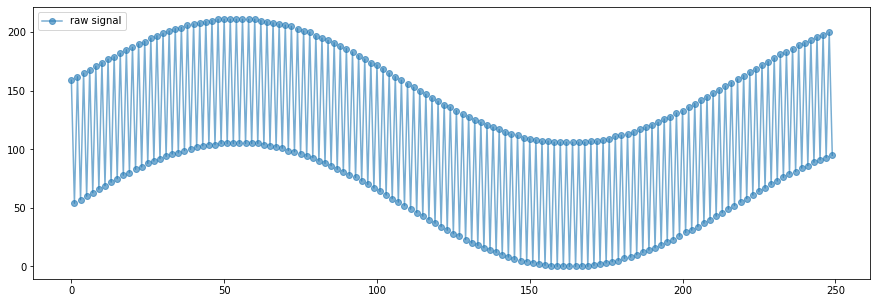

In [29]:
# Now we visualize it:
sig = np.loadtxt("../signal.txt", delimiter='\n')
t = np.arange(len(input_sig)) # array for the x coordinate, just for displaying

plt.figure(figsize=(15, 5))

plt.plot(t, sig, '-o',alpha=.6,label='raw signal')
plt.legend(loc="upper left")

In [30]:
# After being computed on the actual FPGA

In [46]:
# I just copied from the terminal, had some problems in reading from a file :/
fpga = [0,0,0,0,254,245,250,251,251,251,252,252,252,253,253,254,254,254,255,255,255,0,0,0,1,1,1,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,6,6,6,6,6,6,6,5,5,5,5,4,4,4,4,3,3,3,3,2,2,2,1,1,1,1,0,0,0,255,255,254,254,254,253,253,253,252,252,251,251,251,250,250,250,249,249,248,248,248,247,247,247,246,246,245,245,245,244,244,244,243,243,243,242,245,15,17,17,17,17,16,16,16,16,15,15,15,15,14,14,14,14,14,14,14,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,14,14,14,14,14,14,15,15,15,15,15,16,16,16,16,17,17,17,18,15,245,242,243,243,243,244,244,244,245,245,246,246,246,247,247,247,248,248,249,249,249,250,250,250,251,251,252,252,252,253,253,253,254,254,255,255,255,0,0,0,1,1,1,2,2,2,2,3,3]
for i in range(len(fpga)):
    # 2**10 due to truncation of bits
    # 2**9 because I multiplied the coefficients by 2**9
    fpga[i] = (2**10/2**8)*fpga[i]+ 0

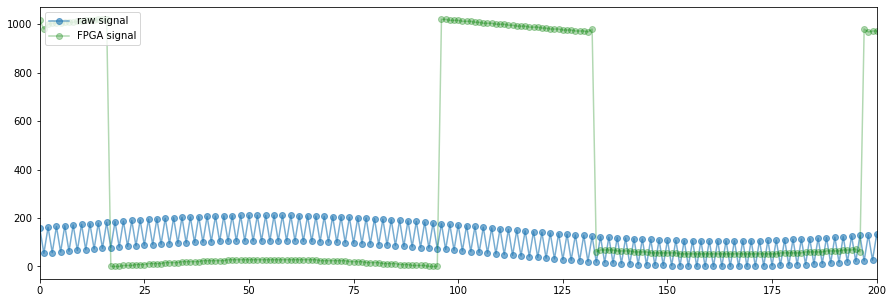

In [47]:
plt.figure(figsize=(15, 5))

t = np.arange(len(input_sig))
plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
t = np.arange(len(fpga))
plt.plot(t-4, fpga, '-o', color='g',alpha=.3,label='FPGA signal')

#plt.title("")
plt.xlim(0,200) #just for the latex report
plt.legend(loc="upper left")